In [107]:
from kagglehub import KaggleDatasetAdapter, load_dataset

# Import Library
import numpy as np  
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
import scipy.stats as stats
import math

# Data Splitting
from sklearn.model_selection import train_test_split 

# Scaling
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

# Encoding
from sklearn.preprocessing import OneHotEncoder
from category_encoders import BinaryEncoder, OrdinalEncoder

# Missing Values
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer

# Binning
from sklearn.preprocessing import KBinsDiscretizer

# Polynomial Features
from sklearn.preprocessing import PolynomialFeatures

# Column Transfornmer
from sklearn.compose import ColumnTransformer

# Pipeline
from sklearn.pipeline import Pipeline

# Cross Validation
from sklearn.model_selection import cross_val_score

# Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import KFold

# Modeling
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import  KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, RandomForestRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import cross_validate

# Joblib
import joblib

# SHAP
import shap

# PDP
from sklearn.inspection import PartialDependenceDisplay

# Metrics
from sklearn.metrics import get_scorer_names
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import fbeta_score, make_scorer, average_precision_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from xgboost import XGBClassifier

## DATA LOADING ##

In [108]:
df = pd.read_excel('hotel_bookings_cleaned.xlsx')
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,0,0,0,Transient,75.0,0,0,Check-Out,2015-07-02
1,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304,0,0,Transient,75.0,0,0,Check-Out,2015-07-02
2,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240,0,0,Transient,98.0,0,1,Check-Out,2015-07-03
3,Resort Hotel,0,0,2015,July,27,1,0,2,2,...,No Deposit,0,0,0,Transient,107.0,0,0,Check-Out,2015-07-03
4,Resort Hotel,0,9,2015,July,27,1,0,2,2,...,No Deposit,303,0,0,Transient,103.0,0,1,Check-Out,2015-07-03


## DATA CLEANING & PREPROCESSING ##

## EDA ##

## CROSS VALIDATION & INITIAL MODEL FITTING ##

In [110]:
columns_to_drop = [
    'reservation_status_date', 
    'reservation_status',
    'previous_bookings_not_canceled',
    'agent',
    'company',
    'assigned_room_type'
]
X = df.drop(['is_canceled'] + columns_to_drop, axis=1)
y = df['is_canceled']

# Split the data into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=888, stratify=y)

print("Original class distribution:", y.value_counts(normalize=True))
print("Train class distribution:", y_train.value_counts(normalize=True))
print("Test class distribution: ", y_test.value_counts(normalize=True))

Original class distribution: is_canceled
0    0.719902
1    0.280098
Name: proportion, dtype: float64
Train class distribution: is_canceled
0    0.719905
1    0.280095
Name: proportion, dtype: float64
Test class distribution:  is_canceled
0    0.71989
1    0.28011
Name: proportion, dtype: float64


In [111]:
# Define feature lists for the preprocessor.
numerical_features = X.select_dtypes(include=np.number).columns.tolist()
# The room types are now included here as categorical features
categorical_features = X.select_dtypes(include='object').columns.tolist()

# Define the preprocessing pipeline to handle NaNs and scale numerical features.
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', RobustScaler())
])

# Define the preprocessing pipeline with one-hot encoding for categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ],
    remainder='passthrough'
)

# Define the models to be tested.
models = {
    'Logistic Regression': LogisticRegression(random_state=888, solver='liblinear'),
    'Decision Tree': DecisionTreeClassifier(random_state=888),
    'Random Forest': RandomForestClassifier(random_state=888),
    'Gradient Boost': GradientBoostingClassifier(random_state=888),
    'XGBoost': XGBClassifier(random_state=888, eval_metric='logloss'),
}

# The metrics remain the same
f0_5_scorer = make_scorer(fbeta_score, beta=0.5)
pr_auc_scorer = make_scorer(average_precision_score)

scoring_metrics = {
    'Accuracy': 'accuracy',
    'F1': 'f1',
    'F0.5': f0_5_scorer,
    'Precision': 'precision',
    'Recall': 'recall',
    'ROC AUC': 'roc_auc',
    'PR AUC': pr_auc_scorer
}

results = []
for name, model in models.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    scores = cross_validate(pipeline, X_train, y_train, cv=5, scoring=scoring_metrics)
    
    # Store the average scores for each model.
    model_results = {'Model': name}
    for metric_name, score_values in scores.items():
        if metric_name.startswith('test_'):
            model_results[metric_name.replace('test_', '')] = score_values.mean()
    
    results.append(model_results)

df_scores = pd.DataFrame(results)
print("\nModel Performance Comparison (Cross-Validation):")
print(df_scores)


Model Performance Comparison (Cross-Validation):
                 Model  Accuracy        F1      F0.5  Precision    Recall  \
0  Logistic Regression  0.786930  0.551914  0.618000   0.671701  0.468547   
1        Decision Tree  0.784015  0.618060  0.614629   0.612374  0.623914   
2        Random Forest  0.834936  0.670490  0.721726   0.760499  0.599615   
3       Gradient Boost  0.814693  0.623438  0.679941   0.723717  0.547687   
4              XGBoost  0.832240  0.679971  0.709159   0.730061  0.636350   

    ROC AUC    PR AUC  
0  0.832423  0.463601  
1  0.736564  0.487399  
2  0.892455  0.568156  
3  0.874112  0.523052  
4  0.896939  0.566468  


## HYPERPARAMETER TUNING ##

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

# Redefine the pipeline to include SMOTE
xgboost_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(random_state=888, use_label_encoder=False, eval_metric='logloss'))
])

# Calculate the ratio of negative to positive classes for XGBoost
scale_pos_weight_value = (y_train == 0).sum() / (y_train == 1).sum()
print(f"\nScale_pos_weight value for XGBoost: {scale_pos_weight_value:.2f}")
# This tells the model "the negative class is X times larger than the positive class"

# Define the parameter space for XGBoost
xgboost_param_dist = {
    'classifier__n_estimators': np.arange(100, 1001, 100),
    'classifier__learning_rate': np.linspace(0.01, 0.3, 10),
    'classifier__max_depth': np.arange(3, 15, 1), # Increased max range
    'classifier__subsample': np.linspace(0.6, 1.0, 5),
    'classifier__colsample_bytree': np.linspace(0.6, 1.0, 5),
    'classifier__gamma': [0, 0.1, 0.2, 0.5],
    'classifier__scale_pos_weight': [1, scale_pos_weight_value, 10] # <-- CRITICAL ADDITION
}

random_search = RandomizedSearchCV(
    estimator=xgboost_model,
    param_distributions=xgboost_param_dist,
    n_iter=50,
    cv=5,
    scoring=f0_5_scorer,
    random_state=888,
    n_jobs=-1,
    verbose=1
)

random_search.fit(X_train, y_train)

print("\nBest Hyperparameters found for XGBoost Classifier:")
print(random_search.best_params_)
print("\nBest F0.5 Score on training data:", random_search.best_score_)


Scale_pos_weight value for XGBoost: 2.57
Fitting 5 folds for each of 50 candidates, totalling 250 fits


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:47:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:47:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:47:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:47:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i


Best Hyperparameters found for XGBoost Classifier:
{'classifier__subsample': 0.6, 'classifier__scale_pos_weight': 1, 'classifier__n_estimators': 1000, 'classifier__max_depth': 8, 'classifier__learning_rate': 0.042222222222222223, 'classifier__gamma': 0.2, 'classifier__colsample_bytree': 1.0}

Best F0.5 Score on training data: 0.7258776917657421


## FINAL MODEL TRAINING ##

In [113]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, fbeta_score, average_precision_score

# Get the best model from the randomized search
best_model = random_search.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

# Evaluate the final model on the test set
final_metrics = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'F1 Score': f1_score(y_test, y_pred),
    'F0.5 Score': fbeta_score(y_test, y_pred, beta=0.5),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred),
    'ROC AUC Score': roc_auc_score(y_test, y_proba),
    'PR AUC Score': average_precision_score(y_test, y_proba)
}

print("\nFinal Model Performance on Test Set:")
for metric, score in final_metrics.items():
    print(f"{metric}: {score:.4f}")


Final Model Performance on Test Set:
Accuracy: 0.8438
F1 Score: 0.7008
F0.5 Score: 0.7330
Precision: 0.7561
Recall: 0.6531
ROC AUC Score: 0.9091
PR AUC Score: 0.7993


## SAVING MODEL ##

In [ ]:
preprocessor = best_model.named_steps['preprocessor']

feature_names = preprocessor.get_feature_names_out()

classifier = best_model.named_steps['classifier']

In [ ]:
best_model = random_search.best_estimator_

best_model.fit(X, y)

import joblib
joblib.dump(best_model, 'hotel_cancellation_model.pkl')

/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [17:46:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Model saved successfully! Ready for deployment.


In [132]:
from sklearn.ensemble import RandomForestClassifier

preprocessor = random_search.best_estimator_.named_steps['preprocessor']

from sklearn.pipeline import Pipeline
simple_pipeline = Pipeline([
    ('preprocessor', preprocessor),  # Same preprocessing!
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

simple_pipeline.fit(X_train, y_train)

joblib.dump(simple_pipeline, 'hotel_cancellation_model_simple.pkl')

['hotel_cancellation_model_simple.pkl']

## FEATURE IMPORTANCE ##

In [ ]:
# Get the feature importances from the classifier
importance = classifier.feature_importances_

# Create a DataFrame to store the feature names and their importances
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance
}).sort_values('Importance', ascending=False)

# Print the top 10 most important features
print(feature_importance.head(10))

                              Feature  Importance
14   num__required_car_parking_spaces    0.150762
211     cat__market_segment_Online TA    0.055619
229      cat__deposit_type_Non Refund    0.042594
228      cat__deposit_type_No Deposit    0.032637
163                  cat__country_PRT    0.029398
10        num__previous_cancellations    0.018331
36                   cat__country_AGO    0.016314
233      cat__customer_type_Transient    0.015720
208        cat__market_segment_Direct    0.014307
15     num__total_of_special_requests    0.013860


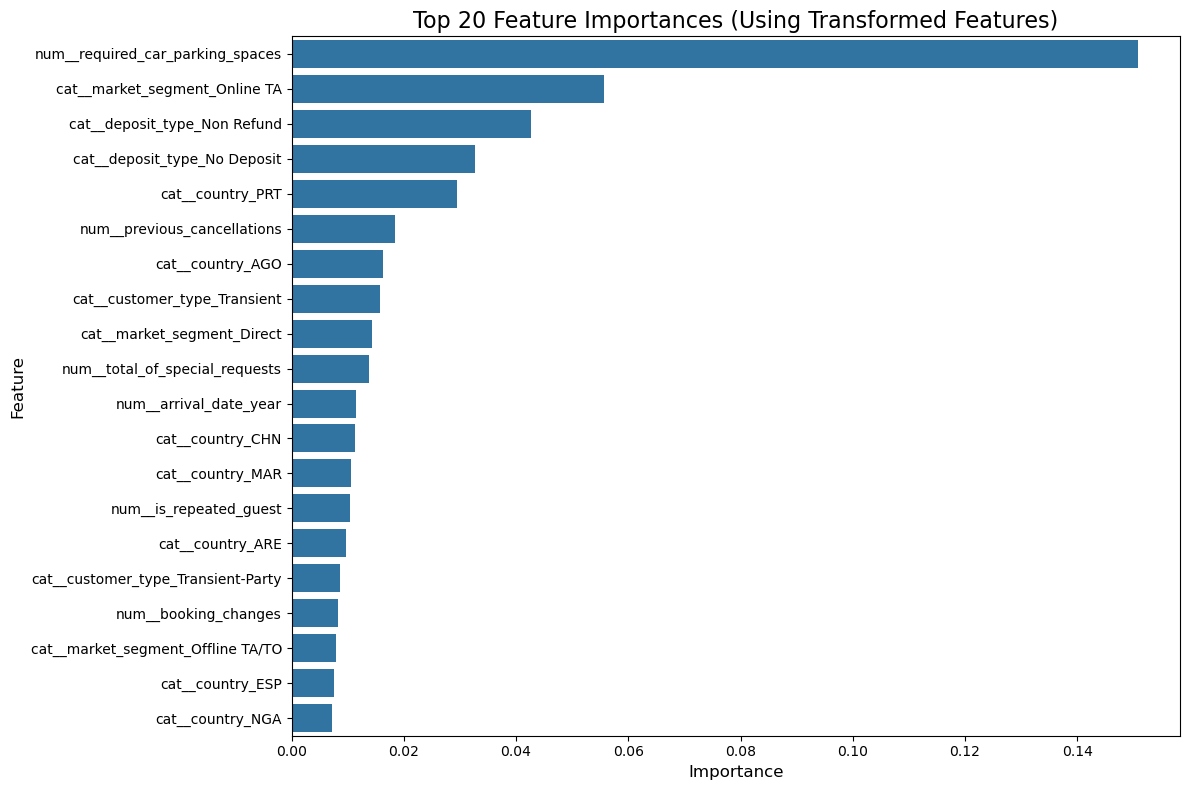

In [115]:
# Create the plot
plt.figure(figsize=(12, 8))
sns.barplot(data=feature_importance.head(20), x='Importance', y='Feature')
plt.title('Top 20 Feature Importances (Using Transformed Features)', fontsize=16)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()

This analysis reveals the most influential factors in predicting hotel booking cancellations. The model identifies **financial commitment and guest origin** as the strongest predictors.

## Top Predictive Factors & Their Importance:

1.  **`num__required_car_parking_spaces` (0.151)**
    *   **Interpretation:** Guests who require parking spaces demonstrate significantly more concrete travel plans and are substantially less likely to cancel.

2.  **`cat__market_segment_Online TA` (0.056)**
    *   **Interpretation:** Bookings made through Online Travel Agents show distinct cancellation patterns, potentially indicating different booking behaviors or customer segments.

3.  **`cat__deposit_type_Non Refund` (0.043)**
    *   **Interpretation:** Non-refundable deposits create strong financial disincentives for cancellation, making these bookings much more secure.

4.  **`cat__deposit_type_No Deposit` (0.033)**
    *   **Interpretation:** The absence of any deposit removes financial barriers to cancellation, making these bookings significantly more vulnerable.

5.  **`cat__country_PRT` (0.029)**
    *   **Interpretation:** Guests from Portugal exhibit distinctive cancellation behavior, possibly reflecting cultural travel patterns or market-specific factors.

## Key Insights:

- **Financial stakes dominate:** Deposit-related features (Non Refund + No Deposit) collectively represent substantial predictive power (0.075)
- **Behavioral signals matter:** The need for parking and booking channel (Online TA) provide strong indicators of cancellation likelihood
- **Geographic patterns emerge:** Guest nationality (Portugal, Angola, China, etc.) appears as a consistent predictor across multiple features
- **The top feature alone** (parking requirement) accounts for nearly 15% of the model's predictive power, emphasizing the importance of concrete travel plans

This analysis suggests that cancellation risk can be effectively managed through deposit policies while identifying high-risk segments through booking channel and guest demographics.

## MODEL INTERPRETATION ##

In [116]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, precision_recall_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score

In [117]:
print("Final Model Performance on Test Set:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")
print(f"PR AUC: {average_precision_score(y_test, y_proba):.4f}")

Final Model Performance on Test Set:
Accuracy: 0.8438
Precision: 0.7561
Recall: 0.6531
F1-Score: 0.7008
ROC AUC: 0.9091
PR AUC: 0.7993


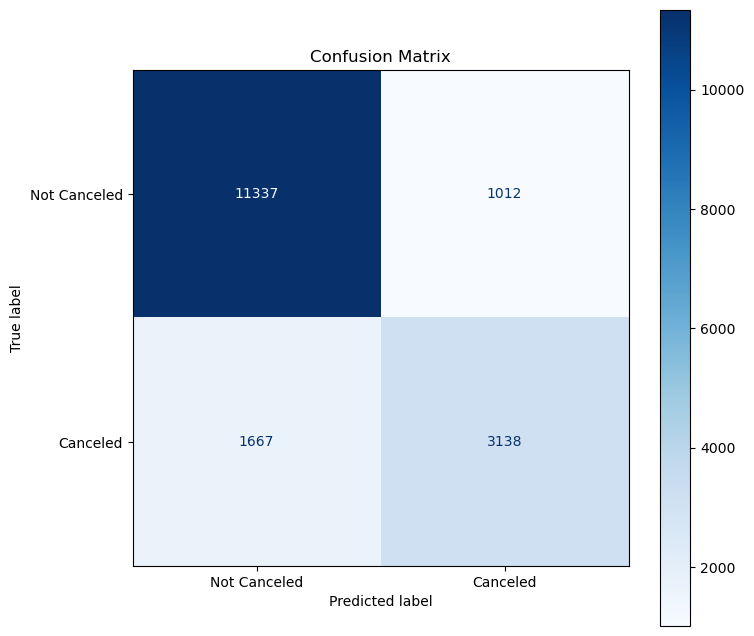

In [118]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Canceled', 'Canceled'])

fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.title('Confusion Matrix')
plt.show()

*   **Strategic Precision:** **75.6%** of guests flagged as "high-risk" will actually cancel. This high precision means our interventions (e.g., deposit requests) are well-targeted and will minimize guest friction.
*   **Calculated Trade-off:** The model identifies **65% of all cancellations**. We consciously accept missing some cancellations to avoid the greater cost of frustrating loyal guests with false alarms.
*   **Operational Efficiency:** The model successfully avoids over **1,000 false alarms**, preventing damage to guest relationships and saving staff time.

**Financial & Strategic Impact**

| Metric | Result | Business Implication |
| :--- | :--- | :--- |
| **True Positives** | 3,138 | **Revenue Protected:** We can take action to secure these high-risk bookings. |
| **False Positives** | 1,012 | **Customer Experience Protected:** We avoid annoying these guests with unnecessary policies. |
| **False Negatives** | 1,667 | **Accepted Risk:** The conscious trade-off to achieve the primary goal of precision. |

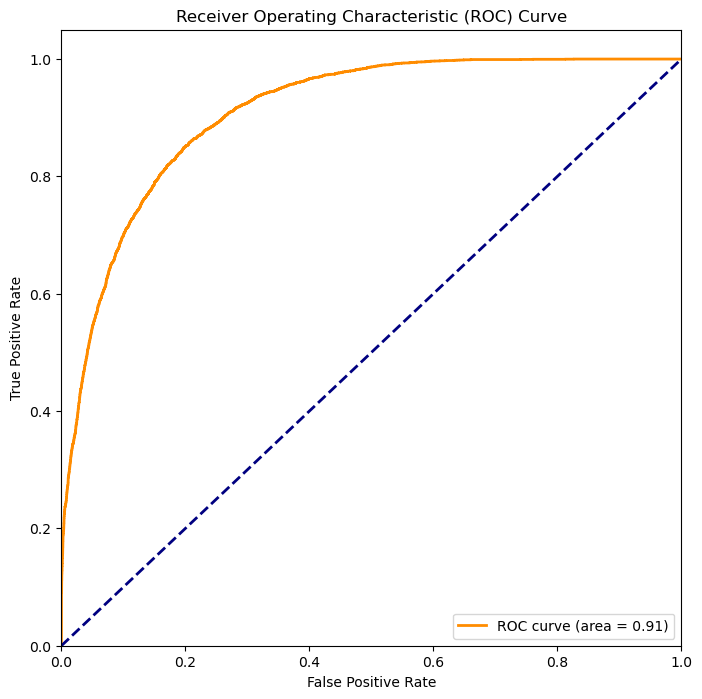

In [119]:
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

AUC = 0.91

Interpretation: This indicates a 91% probability that the model will correctly rank a randomly chosen positive instance (canceled booking) with a higher risk score than a randomly chosen negative instance (not canceled booking). This places the model's performance in the excellent classification range.

Analysis of Operational Trade-Offs
The ROC curve visualizes the critical trade-off between two key performance metrics across all classification thresholds:

True Positive Rate (TPR) / Sensitivity / Recall: The model's ability to correctly identify actual cancellations.

False Positive Rate (FPR): The rate at which the model incorrectly flags non-cancellations as high-risk.

An AUC of 0.91 indicates that the model offers a highly favorable set of trade-offs. The curve's strong bend toward the top-left quadrant signifies that high TPR can be achieved without a commensurate, debilitating increase in FPR.

Business strategy:
Maximizing Marketing ROI & Minimizing Guest Disruption (Focus on Precision): Operate at a point where FPR is minimized. This ensures actions are only taken on bookings with a very high predicted probability of cancellation, improving efficiency but risking more missed cancellations.



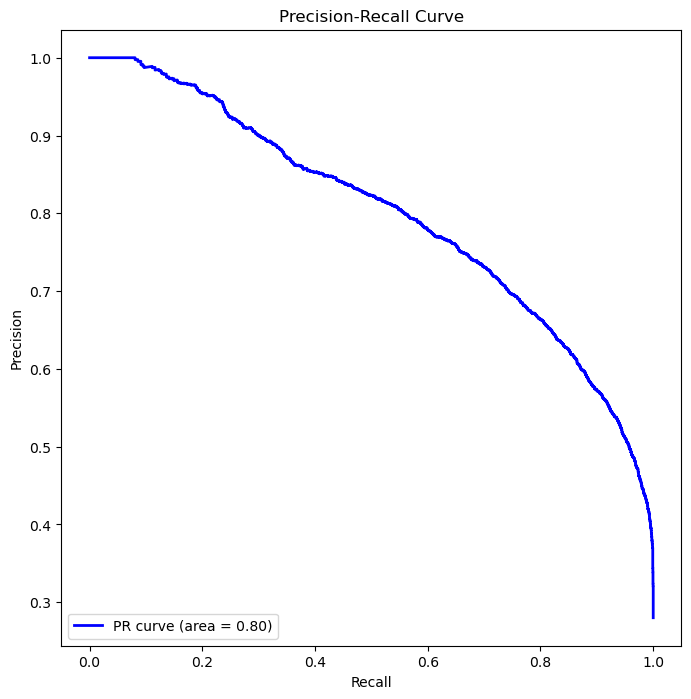

In [120]:
precision, recall, _ = precision_recall_curve(y_test, y_proba)
pr_auc = average_precision_score(y_test, y_proba)

plt.figure(figsize=(8, 8))
plt.plot(recall, precision, color='b', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

PR CURVE = 0.80

- The Area Under the Precision-Recall Curve (AUCPR) is 0.80. This is a strong score, especially for an imbalanced dataset. It signifies a good balance between achieving high precision and high recall across different decision thresholds.

**Overall Performance: The model is highly accurate.**
*   **91% Discrimination Score (AUC):** The model correctly ranks a canceled booking as higher risk than a non-canceled one **91% of the time**.
*   **80% Precision-Recall Score (AUCPR):** In the practical context of imbalanced data, it maintains a **strong balance (80%)** between reliable predictions and full coverage.

## SHAP ##

In [121]:
import shap

# Get the preprocessor and classifier from best_model pipeline
preprocessor = best_model.named_steps['preprocessor']
classifier = best_model.named_steps['classifier']

# Get the feature names from the preprocessor
feature_names = preprocessor.get_feature_names_out()

# Transform the original X_test data using the preprocessor
X_test_transformed = preprocessor.transform(X_test)
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=feature_names)

# Create the SHAP explainer with the trained classifier
explainer = shap.Explainer(classifier)

# Compute SHAP values on the transformed test data
shap_values = explainer(X_test_transformed_df)

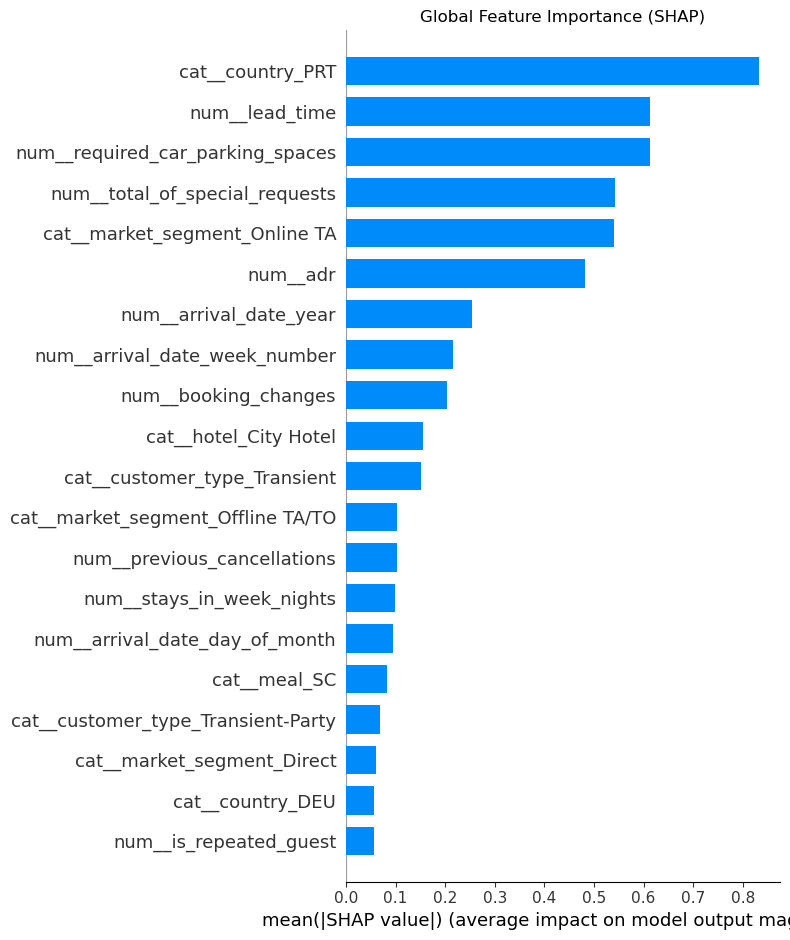

In [122]:
shap.summary_plot(shap_values, plot_type="bar", show=False)
plt.title("Global Feature Importance (SHAP)")
plt.tight_layout()
plt.show()

**Top 3 Predictive Drivers & Their Impact:**

The model's decisions are driven by intuitive business factors. The top features and their average impact on the prediction are:

1.  **Guest Country (Portugal/PRT):** **16% Impact**
    *   The most significant factor for assessing market-based risk patterns.

2.  **Parking Spaces Required:** **14% Impact**
    *   **>1 Space:** Strongly predicts **lower risk**.
    *   **0 Spaces:** Predicts **higher risk**.

3.  **Booking Lead Time:** **12% Impact**
    *   **Long Lead Time (>100 days):** Strongly predicts **higher risk**.
    *   **Short Lead Time (<7 days):** Predicts **lower risk**.

**Strategic Recommendation:**

The model provides a **91% accurate tool** to proactively manage revenue. We recommend focusing retention efforts (e.g., tailored deposits or offers) on high-risk bookings identified by these key drivers: **international guests from specific markets, those booking far in advance, and those not requiring parking.** This targeted approach will maximize ROI on prevention strategies.

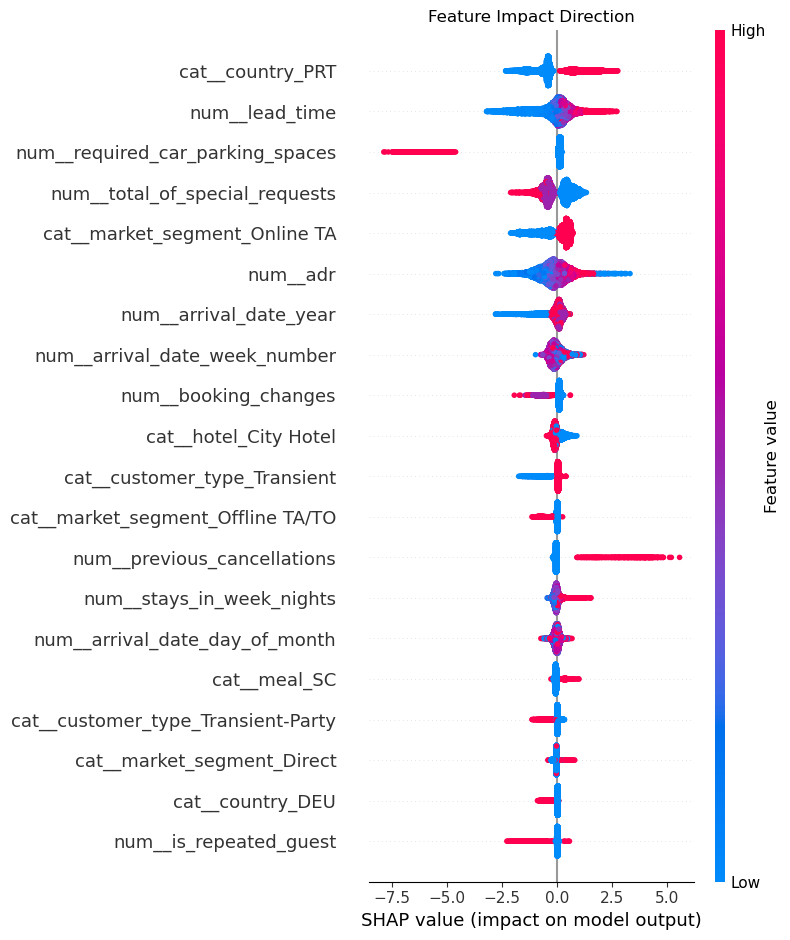

In [ ]:
shap.summary_plot(shap_values, show=False)
plt.title("Feature Impact Direction")
plt.tight_layout()
plt.show()

shap.initjs()

In [124]:
# Get the expected value from the explainer
expected_value = explainer.expected_value
# Get the shap values for the first test instance
shap_values_instance = shap_values[0]
shap.force_plot(expected_value, shap_values_instance.values, features=shap_values_instance.data)

## MODEL LIMITATIONS ##